* * *
### Objective:
This notebook outlines the process of modelling energy systems for remote communities. There are three main parts for modelling the energy systems.
 1. Input data
 2. Optimization
 3. Visualization
* * * 

In [1]:
import yaml
from pyehub.outputter import pretty_print # To print the results in inderstandable way.
from pyehub.energy_hub.ehub_model import EHubModel # importing EHubModel to minimize the total cost of the system.
from pyehub.energy_hub.utils import constraint, constraint_list

import pickle
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# Introduction

# Input data
There are three main inputs to the energy hub model which are hourly electricity demand, hourly solar and wind power and technical, economic and environmental data. Electricity demand is calculated by EnergyPlus. Hourly solar and wind power are obtained from "Renewable.ninja" (https://www.renewables.ninja/).


# Base scenario: only diesel generator
The optimization process has been done using BESOS Platform (https://besos.uvic.ca/). 

## Optimization: running Energy hub model

#### BC

In [2]:
excel_file = 'data/BC/BC_Input_S1.xlsx'
my_model = EHubModel(excel=excel_file) 
results_BC = my_model.solve() # solve the model and get back our results
with open ('data/BC/BC_output_base.results','wb') as res:
    pickle.dump(results_BC,res)
#pretty_print(results) # print the results to the console

#### Yukon

In [5]:
excel_file = 'data/YT/YT_Input_S1.xlsx'
my_model = EHubModel(excel=excel_file) 
results_YT = my_model.solve() # solve the model and get back our results
with open ('data/YT/YT_output_base.results','wb') as res:
    pickle.dump(results_YT,res)
#pretty_print(results) # print the results to the console

## Vizualisation of the results
The result of the optimization is a nested dictionnary.

Let's have a look on some interesting values.

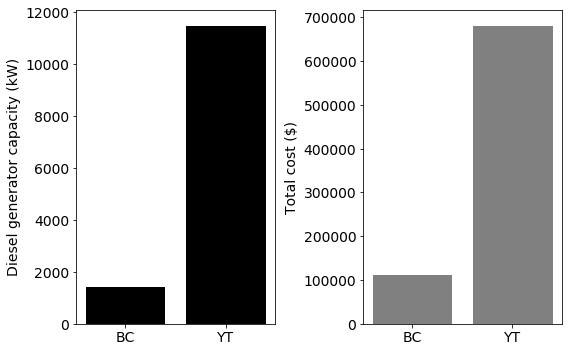

In [6]:
diesel_cap_BC = results_BC['solution']['capacity_tech']['Diesel generator']
diesel_cap_YT = results_YT['solution']['capacity_tech']['Diesel generator']

total_cost_BC = results_BC['solution']['total_cost']
total_cost_YT = results_YT['solution']['total_cost']

# set a new figure
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

# set width of bar
barWidth = 0.8
labels = ['BC','YT']

# set height of bar
bars1 = [diesel_cap_BC , diesel_cap_YT]
bars2 = [total_cost_BC , total_cost_YT]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
 
# Make the plot
ax[0].bar(r1, bars1, color='k', width=barWidth, edgecolor='white', label='Total Cost($/person)')

ax[0].set_ylabel('Diesel generator capacity (kW)', fontsize=14)
ax[0].set_xticks(r1)
ax[0].set_xticklabels(labels)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)

# Make the plot
ax[1].bar(r1, bars2, color='grey', width=barWidth, edgecolor='white', label='Total Carbon(kg/person)')

ax[1].set_ylabel('Total cost ($)', fontsize=14)
ax[1].set_xticks(r1)
ax[1].set_xticklabels(labels)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)

# Avoid overlapping graphs
plt.tight_layout()

# Scenario 1: renewable energy and only cost optimization
We add the possibility to add PV panels and wind turbines to meet energy demand.
## Optimization
To do that, the input Excel file of EnergyHub is modified in order to add this possibility. 
### BC

In [8]:
excel_file = 'data/BC/BC_Input_S2.xlsx' 
my_model = EHubModel(excel=excel_file) 
results_100_BC = my_model.solve() # solve the model and get back our results
with open ('data/BC/BC_output_S4_100.results','wb') as res: # save the results
    pickle.dump(results_100_BC,res)
#pretty_print(results) # print the results to the console

### Yukon

In [9]:
excel_file = 'data/YT/YT_Input_S2.xlsx' 
my_model = EHubModel(excel=excel_file) 
results_100_YT = my_model.solve() # solve the model and get back our results
with open ('data/YT/YT_output_S4_100.results','wb') as res: # save the results
    pickle.dump(results_100_YT,res)
#pretty_print(results) # print the results to the console

## Vizualisation
Let's compare the solution.

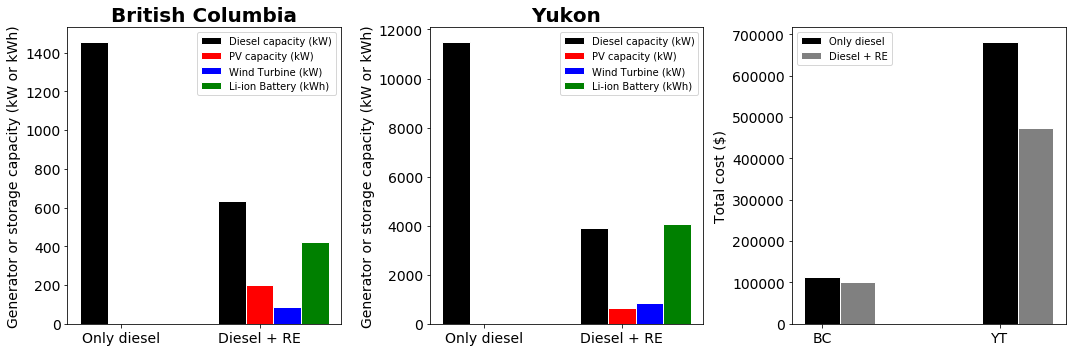

In [10]:
diesel_cap_100_BC = results_100_BC['solution']['capacity_tech']['Diesel generator']
diesel_cap_100_YT = results_100_YT['solution']['capacity_tech']['Diesel generator']
PV_cap_100_BC = results_100_BC['solution']['capacity_tech']['PV']
PV_cap_100_YT = results_100_YT['solution']['capacity_tech']['PV']
WT_cap_100_BC = results_100_BC['solution']['capacity_tech']['WT']
WT_cap_100_YT = results_100_YT['solution']['capacity_tech']['WT']
Liion_cap_100_BC = results_100_BC['solution']['capacity_storage']['Li-ion']
Liion_cap_100_YT = results_100_YT['solution']['capacity_storage']['Li-ion']

total_cost_100_BC = results_100_BC['solution']['total_cost']
total_cost_100_YT = results_100_YT['solution']['total_cost']

# set a new figure
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# set width of bar
barWidth = 0.2
labels = ['Only diesel', 'Diesel + RE']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3] 
 
# Make the plot
# set height of bar
bars1 = [diesel_cap_BC , diesel_cap_100_BC]
bars2 = [0 , PV_cap_100_BC]
bars3 = [0 , WT_cap_100_BC]
bars4 = [0 , Liion_cap_100_BC]
ax[0].bar(r1, bars1, color='k', width=barWidth, edgecolor='white', label='Diesel capacity (kW)')
ax[0].bar(r2, bars2, color='r', width=barWidth, edgecolor='white', label='PV capacity (kW)')
ax[0].bar(r3, bars3, color='b', width=barWidth, edgecolor='white', label='Wind Turbine (kW)')
ax[0].bar(r4, bars4, color='g', width=barWidth, edgecolor='white', label='Li-ion Battery (kWh)')

ax[0].set_title('British Columbia', fontweight='bold', fontsize = 20)
ax[0].set_ylabel('Generator or storage capacity (kW or kWh)', fontsize=14)
ax[0].legend()
ax[0].set_xticks(r2)
ax[0].set_xticklabels(labels)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)

# Make the plot
# set height of bar
bars1 = [diesel_cap_YT , diesel_cap_100_YT]
bars2 = [0 , PV_cap_100_YT]
bars3 = [0 , WT_cap_100_YT]
bars4 = [0 , Liion_cap_100_YT]
ax[1].bar(r1, bars1, color='k', width=barWidth, edgecolor='white', label='Diesel capacity (kW)')
ax[1].bar(r2, bars2, color='r', width=barWidth, edgecolor='white', label='PV capacity (kW)')
ax[1].bar(r3, bars3, color='b', width=barWidth, edgecolor='white', label='Wind Turbine (kW)')
ax[1].bar(r4, bars4, color='g', width=barWidth, edgecolor='white', label='Li-ion Battery (kWh)')

ax[1].set_title('Yukon', fontweight='bold', fontsize = 20)
ax[1].set_ylabel('Generator or storage capacity (kW or kWh)', fontsize=14)
ax[1].legend()
ax[1].set_xticks(r2)
ax[1].set_xticklabels(labels)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].tick_params(axis='y', labelsize=14)

# Make the plot
# set height of bar
bars1 = [total_cost_BC , total_cost_YT]
bars2 = [total_cost_100_BC , total_cost_100_YT]
ax[2].bar(r1, bars1, color='k', width=barWidth, edgecolor='white', label='Only diesel')
ax[2].bar(r2, bars2, color='grey', width=barWidth, edgecolor='white', label='Diesel + RE')

ax[2].set_ylabel('Total cost ($)', fontsize=14)
ax[2].legend()
ax[2].set_xticks(r1)
ax[2].set_xticklabels(['BC','YT'])
ax[2].tick_params(axis='x', labelsize=14)
ax[2].tick_params(axis='y', labelsize=14)

# Avoid overlapping graphs
plt.tight_layout()

Obviously, adding some renewable energies is cost effective in both cases!

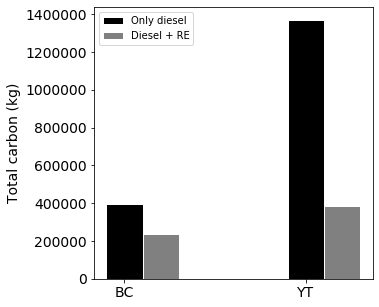

In [11]:
total_co2_BC = results_BC['solution']['total_carbon']
total_co2_YT = results_YT['solution']['total_carbon']
total_co2_100_BC = results_100_BC['solution']['total_carbon']
total_co2_100_YT = results_100_YT['solution']['total_carbon']

# set a new figure
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# set width of bar
barWidth = 0.2

# Make the plot
# set height of bar
bars1 = [total_co2_BC , total_co2_YT]
bars2 = [total_co2_100_BC , total_co2_100_YT]
ax.bar(r1, bars1, color='k', width=barWidth, edgecolor='white', label='Only diesel')
ax.bar(r2, bars2, color='grey', width=barWidth, edgecolor='white', label='Diesel + RE')

ax.set_ylabel('Total carbon (kg)', fontsize=14)
ax.legend()
ax.set_xticks(r1)
ax.set_xticklabels(['BC','YT'])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

...and decrease the amount of carbon emissions.

# Scenario 2 : multi-objective optimization
What if we constraint the carbon emissions besides the cost?

To do that, we first add a carbon constraint to the energy hub model. 
Then, by using epsilon constraint method, the model will be solved for 75%, 50% 25% of carbon emissions of scenario 1.
## Add Carbon constraint

In [12]:
# add carbon contraint. 

class CarbonEHubModel(EHubModel):
    MAX_CARBON = 0

    def __init__(self, *, excel=None, request=None, max_carbon=0):
        super().__init__(excel=excel, request=request)
        if max_carbon is not None:
            self.MAX_CARBON = max_carbon

    @constraint()
    def max_carbon_level(self):
        return self.total_carbon <= float(self.MAX_CARBON)

## Optimization

### BC

In [14]:
#75% carbon
my_model = CarbonEHubModel(excel=excel_file, max_carbon = results_100_BC['solution']['total_carbon']*0.75 ) 
results_75 = my_model.solve() # solve the model and get back results
with open ('data/BC/BC_output_S3_75.results','wb') as res:
    pickle.dump(results_75,res)
#50% carbon
my_model = CarbonEHubModel(excel=excel_file, max_carbon = results_100_BC['solution']['total_carbon']*0.50 ) 
results_50 = my_model.solve() # solve the model and get back results
with open ('data/BC/BC_output_S2_50.results','wb') as res:
    pickle.dump(results_50,res)
#25% carbon
my_model = CarbonEHubModel(excel=excel_file, max_carbon = results_100_BC['solution']['total_carbon']*0.25 ) 
results_25 = my_model.solve() # solve the model and get back results
with open ('data/BC/BC_output_S1_25.results','wb') as res:
    pickle.dump(results_25,res)
#0% carbon
# This scenario doesn't work with glpk so I rerun it on my computer with Cplex!

### Yukon

In [15]:
#75% carbon
my_model = CarbonEHubModel(excel=excel_file, max_carbon = results_100_YT['solution']['total_carbon']*0.75 ) 
results_75 = my_model.solve() # solve the model and get back results
with open ('data/YT/YT_output_S3_75.results','wb') as res:
    pickle.dump(results_75,res)
#50% carbon
my_model = CarbonEHubModel(excel=excel_file, max_carbon = results_100_YT['solution']['total_carbon']*0.50 ) 
results_50 = my_model.solve() # solve the model and get back results
with open ('data/YT/YT_output_S2_50.results','wb') as res:
    pickle.dump(results_50,res)
#25% carbon
my_model = CarbonEHubModel(excel=excel_file, max_carbon = results_100_YT['solution']['total_carbon']*0.25 ) 
results_25 = my_model.solve() # solve the model and get back results
with open ('data/YT/YT_output_S1_25.results','wb') as res:
    pickle.dump(results_25,res)
#0% carbon
# This scenario doesn't work with glpk so I rerun it on my computer with Cplex!

## Visualization
To facilitate the vizualisation, a dataframe is build which summarizes all the results.

In [19]:
# dataframe for requiered result
Info = {"ID":[], "Region":[], "Scenario":[], "PV_cap (kW)":[], "Wind_cap (kW)":[], "Diesel generator_cap (kW)":[],
        "Li-ion Battery (kWh)":[], "Total_cost ($)":[], "Total_carbon (kg)":[], "TotalCost ($/person)":[], "Total Carbon (kg/person)":[]}
region = ['BC','YT']
Population = {'BC':90,'YT':221}
findScenario = re.compile('[A-Z]{2}_output_S\d_(\d+).results')

for region in region:
    for filename in os.listdir('./data/' + region):    
        if filename.endswith(".results"):
            with open(os.path.join('./data/' + region,filename), 'rb') as f:
                Result = pickle.load(f)
                ID = filename
                # Test case
                Region = region
                Scenario = 'RES(' + findScenario.findall(filename)[0] + ')' if findScenario.match(filename) else 'Base'
                # Converters capacity
                Tech_cap_PV = round(Result['solution']['capacity_tech']['PV'],2)
                Tech_cap_wind = round(Result['solution']['capacity_tech']['WT'],2)
                Tech_cap_diesel = round(Result['solution']['capacity_tech']['Diesel generator'],2)
                # Storage capacity
                battery_cap = Result['solution']['capacity_storage']['Li-ion']
                # Total cost and carbon
                cost = Result['solution']['total_cost']
                carbon = Result['solution']['total_carbon']
                cost_per_person = round((Result['solution']['total_cost'])/(Population[region]))
                carbon_per_person = round((Result['solution']['total_carbon'])/(Population[region]))
                
                Info["ID"].append(ID)
                Info["Region"].append(Region)
                Info["Scenario"].append(Scenario)
                Info["PV_cap (kW)"].append(Tech_cap_PV)
                Info["Wind_cap (kW)"].append(Tech_cap_wind)
                Info["Diesel generator_cap (kW)"].append(Tech_cap_diesel)
                Info["Li-ion Battery (kWh)"].append(battery_cap)
                Info["Total_cost ($)"].append(cost)
                Info["Total_carbon (kg)"].append(carbon)
                Info["TotalCost ($/person)"].append(cost_per_person)
                Info["Total Carbon (kg/person)"].append(carbon_per_person)

                
df = pd.DataFrame(data = Info) # combine all the data in a dataframe

df.sort_values(by=['ID'], inplace=True) 
#df = df.reset_index() 
df.set_index('ID', inplace = True)
df

,Region,Scenario,PV_cap (kW),Wind_cap (kW),Diesel generator_cap (kW),Li-ion Battery (kWh),Total_cost ($),Total_carbon (kg),TotalCost ($/person),Total Carbon (kg/person)
ID,,,,,,,,,,
BC_output_S1_25.results,BC,RES(25),1705.53,1807.62,1016.47,9357.550,653607.0,58982.7,7262,655
BC_output_S2_50.results,BC,RES(50),1408.88,1466.70,1659.21,6550.910,545965.0,117965.0,6066,1311
BC_output_S3_75.results,BC,RES(75),1233.88,1211.18,2264.56,5506.910,504023.0,176948.0,5600,1966
BC_output_S4_100.results,BC,RES(100),201.67,86.04,636.23,420.528,100192.0,235931.0,1113,2621
BC_output_base.results,BC,Base,0.00,0.00,1457.09,0.000,112698.0,397720.0,1252,4419
YT_output_S1_25.results,YT,RES(25),1564.19,1538.46,1392.89,7300.900,575092.0,96517.5,2602,437
YT_output_S2_50.results,YT,RES(50),1163.60,1162.46,2348.62,5433.330,496894.0,193035.0,2248,873
YT_output_S3_75.results,YT,RES(75),826.41,968.25,2774.84,5212.960,477598.0,289552.0,2161,1310
YT_output_S4_100.results,YT,RES(100),664.23,839.44,3888.77,4075.440,472956.0,386070.0,2140,1747


### Optimal designs

Text(0.5, 1.0, 'Yukon')

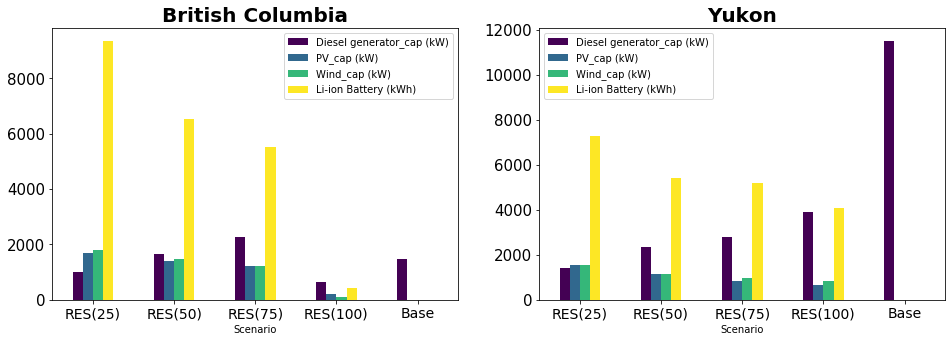

In [20]:
Results_BC = df[df.Region=='BC']
Results_YT = df[df.Region=='YT']

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

viewColumns = ['Diesel generator_cap (kW)', 'PV_cap (kW)', 'Wind_cap (kW)', 'Li-ion Battery (kWh)']
Results_BC.plot.bar(x="Scenario", y=viewColumns, colormap='viridis', ax=ax[0])

ax[0].tick_params(axis='x', labelsize=14, labelrotation=0)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_title('British Columbia',fontweight='bold', fontsize = 20)

viewColumns = ['Diesel generator_cap (kW)', 'PV_cap (kW)', 'Wind_cap (kW)', 'Li-ion Battery (kWh)']
Results_YT.plot.bar(x="Scenario", y=viewColumns, colormap='viridis', ax=ax[1])

ax[1].tick_params(axis='x', labelsize=14, labelrotation=0)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_title('Yukon',fontweight='bold', fontsize = 20)

### Costs and carbon emissions

Text(0.5, 1.0, 'Yukon')

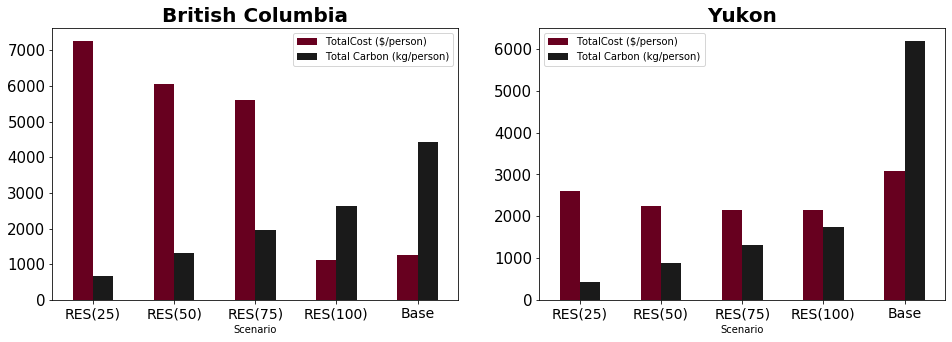

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

viewColumns = ['TotalCost ($/person)', 'Total Carbon (kg/person)']
Results_BC.plot.bar(x="Scenario", y=viewColumns, colormap='RdGy', ax=ax[0])

ax[0].tick_params(axis='x', labelsize=14, labelrotation=0)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_title('British Columbia',fontweight='bold', fontsize = 20)

viewColumns = ['TotalCost ($/person)', 'Total Carbon (kg/person)']
Results_YT.plot.bar(x="Scenario", y=viewColumns, colormap='RdGy', ax=ax[1])

ax[1].tick_params(axis='x', labelsize=14, labelrotation=0)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_title('Yukon',fontweight='bold', fontsize = 20)

### Pareto front

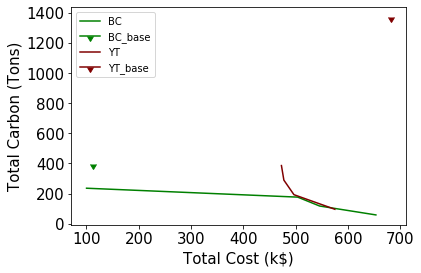

In [23]:
#All total demand are in GWh, here converted to MWh 
#BC
Total_cost_BC = Results_BC['Total_cost ($)'][Results_BC.Scenario != 'Base']/1000
Total_carbon_BC = Results_BC['Total_carbon (kg)'][Results_BC.Scenario != 'Base']/1000

Total_cost_BC_b = Results_BC['Total_cost ($)'][Results_BC.Scenario == 'Base']/1000
Total_carbon_BC_b = Results_BC['Total_carbon (kg)'][Results_BC.Scenario == 'Base']/1000

# Yukon
Total_cost_YT = Results_YT['Total_cost ($)'][Results_YT.Scenario != 'Base']/1000
Total_carbon_YT = Results_YT['Total_carbon (kg)'][Results_YT.Scenario != 'Base']/1000

Total_cost_YT_b = Results_YT['Total_cost ($)'][Results_YT.Scenario == 'Base']/1000
Total_carbon_YT_b = Results_YT['Total_carbon (kg)'][Results_YT.Scenario == 'Base']/1000

plt.plot(Total_cost_BC, Total_carbon_BC, label = 'BC' ,color = 'g')
plt.plot(Total_cost_BC_b, Total_carbon_BC_b, label = 'BC_base',marker = 11, color = 'g')
plt.plot(Total_cost_YT, Total_carbon_YT, label = 'YT',color = 'maroon')
plt.plot(Total_cost_YT_b, Total_carbon_YT_b, label = 'YT_base',marker = 11, color = 'maroon')
#plt.plot(xvals_AB, yinterp_AB, '-x')
plt.xlabel('Total Cost (k$)', fontsize = 15)
plt.ylabel('Total Carbon (Tons)', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.xlim(0,500)
#plt.ylim(0,600)
plt.legend()
plt.show()